# Multi-Degree-of-Freedom (MDOF) System Analysis

This notebook analyzes SDOF, 2-DOF, and 3-DOF systems with base excitation, computing transmissibility characteristics for vibration isolation applications.

## System Configuration
- **SDOF**: Top mass connected to base
- **2-DOF**: Top and middle masses connected to base  
- **3-DOF**: Top, middle, and lowest masses connected to base

## Analysis Features
- Uncoupled natural frequency calculations
- Configurable damping ratios
- Transmissibility analysis (base-relative and mass-relative)
- Comprehensive frequency response plotting

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.signal import find_peaks

# Import MDOF system utilities
from mdof_utilities import SDOF_System, TDOF_System, THREEDOF_System, time_response, shock_response_spectrum

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2

print("✅ Libraries imported successfully")
print("✅ MDOF utilities imported: SDOF_System, TDOF_System, THREEDOF_System, time_response, shock_response_spectrum")

✅ Libraries imported successfully
✅ MDOF utilities imported: SDOF_System, TDOF_System, THREEDOF_System, time_response, shock_response_spectrum


## System Parameters Configuration

Define masses, stiffnesses, and damping for all system configurations.

In [2]:
# =============================================================================
# SYSTEM PARAMETERS DEFINITION
# =============================================================================

# Mass Configuration (kg)
# ----------------------
m_top = 0.75      # Top mass (smallest, highest frequency)
m_middle = 15.0   # Middle mass 
m_lowest = 300.0  # Lowest mass (largest, lowest frequency)

print("Mass Configuration:")
print(f"  Top mass (m3):    {m_top:.2f} kg")
print(f"  Middle mass (m2): {m_middle:.1f} kg") 
print(f"  Lowest mass (m1): {m_lowest:.0f} kg")
print(f"  Mass ratios:      {m_lowest/m_top:.0f}:{m_middle/m_top:.0f}:1")

# Spring Stiffness Configuration (N/m)
# ------------------------------------
# These determine the uncoupled natural frequencies
k_top = 3.36e6     # Top spring (highest stiffness for high frequency)
k_middle = 4.19e6  # Middle spring
k_lowest = 2.09e7  # Lowest spring (highest stiffness for large mass)

print(f"\nSpring Stiffness Configuration:")
print(f"  Top spring (k3):    {k_top:.2e} N/m")
print(f"  Middle spring (k2): {k_middle:.2e} N/m")
print(f"  Lowest spring (k1): {k_lowest:.2e} N/m")

# Damping Configuration
# --------------------
damping_percent = 5.0  # Percent critical damping for all springs
damping_ratio = damping_percent / 100.0

print(f"\nDamping Configuration:")
print(f"  Damping ratio: {damping_percent:.1f}% critical damping")

# Calculate uncoupled natural frequencies
# ---------------------------------------
# For uncoupled systems: fn = sqrt(k/m)/(2*pi)
fn_top_uncoupled = np.sqrt(k_top / m_top) / (2 * np.pi)
fn_middle_uncoupled = np.sqrt(k_middle / m_middle) / (2 * np.pi)  
fn_lowest_uncoupled = np.sqrt(k_lowest / m_lowest) / (2 * np.pi)

print(f"\nUncoupled Natural Frequencies:")
print(f"  Top mass (f3):    {fn_top_uncoupled:.2f} Hz")
print(f"  Middle mass (f2): {fn_middle_uncoupled:.2f} Hz")
print(f"  Lowest mass (f1): {fn_lowest_uncoupled:.2f} Hz")

# Check frequency relationships
print(f"\nFrequency Relationships:")
print(f"  f2/f1 ratio: {fn_middle_uncoupled/fn_lowest_uncoupled:.3f} ({np.log2(fn_middle_uncoupled/fn_lowest_uncoupled):.2f} octaves)")
print(f"  f3/f2 ratio: {fn_top_uncoupled/fn_middle_uncoupled:.3f} ({np.log2(fn_top_uncoupled/fn_middle_uncoupled):.2f} octaves)")
print(f"  f3/f1 ratio: {fn_top_uncoupled/fn_lowest_uncoupled:.3f} ({np.log2(fn_top_uncoupled/fn_lowest_uncoupled):.2f} octaves)")

# Calculate damping coefficients
# -----------------------------
# c = 2 * zeta * sqrt(k * m)
c_top = 2 * damping_ratio * np.sqrt(k_top * m_top)
c_middle = 2 * damping_ratio * np.sqrt(k_middle * m_middle)
c_lowest = 2 * damping_ratio * np.sqrt(k_lowest * m_lowest)

print(f"\nDamping Coefficients:")
print(f"  Top damper (c3):    {c_top:.1f} N⋅s/m")
print(f"  Middle damper (c2): {c_middle:.1f} N⋅s/m")
print(f"  Lowest damper (c1): {c_lowest:.1f} N⋅s/m")

print(f"\n{'='*60}")
print("✅ System parameters configured successfully")
print(f"{'='*60}")

Mass Configuration:
  Top mass (m3):    0.75 kg
  Middle mass (m2): 15.0 kg
  Lowest mass (m1): 300 kg
  Mass ratios:      400:20:1

Spring Stiffness Configuration:
  Top spring (k3):    3.36e+06 N/m
  Middle spring (k2): 4.19e+06 N/m
  Lowest spring (k1): 2.09e+07 N/m

Damping Configuration:
  Damping ratio: 5.0% critical damping

Uncoupled Natural Frequencies:
  Top mass (f3):    336.87 Hz
  Middle mass (f2): 84.12 Hz
  Lowest mass (f1): 42.01 Hz

Frequency Relationships:
  f2/f1 ratio: 2.002 (1.00 octaves)
  f3/f2 ratio: 4.005 (2.00 octaves)
  f3/f1 ratio: 8.019 (3.00 octaves)

Damping Coefficients:
  Top damper (c3):    158.7 N⋅s/m
  Middle damper (c2): 792.8 N⋅s/m
  Lowest damper (c1): 7918.3 N⋅s/m

✅ System parameters configured successfully


## 1-DOF System Analysis

Single degree of freedom system using only the top mass connected to base.

SDOF System Properties:
  Mass: 0.75 kg
  Stiffness: 3.36e+06 N/m
  Damping: 158.7 N⋅s/m
  Natural frequency: 336.87 Hz
  Damping ratio: 0.050 (5.0%)

SDOF Transmissibility:
  Peak: 10.05 at 335.4 Hz
  Natural frequency: 336.87 Hz


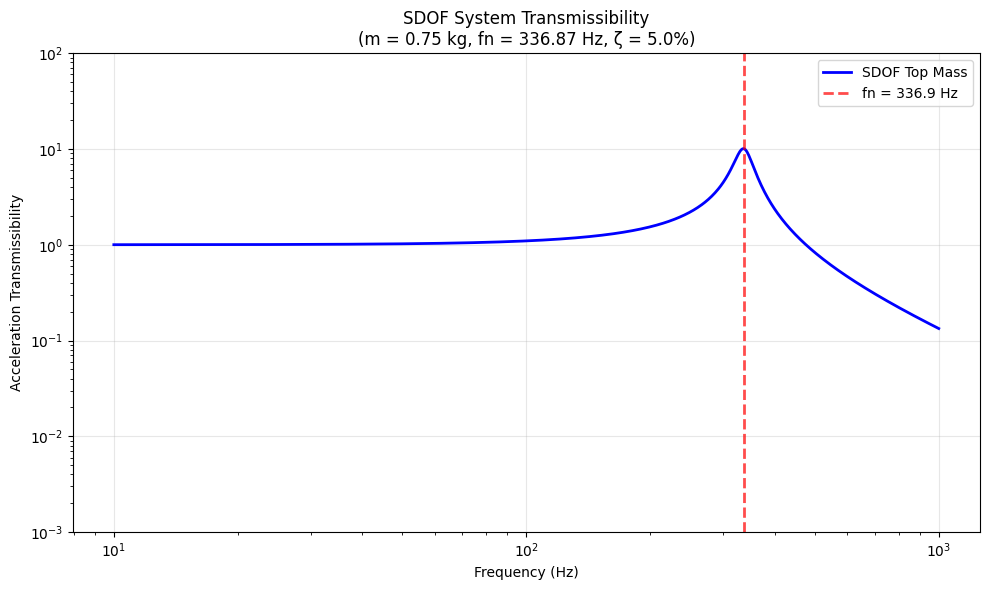

✅ SDOF analysis completed


In [3]:
# =============================================================================
# SDOF SYSTEM ANALYSIS
# =============================================================================

# Create SDOF system (top mass only)
sdof = SDOF_System(m_top, k_top, c_top)

print("SDOF System Properties:")
print(f"  Mass: {sdof.m:.2f} kg")
print(f"  Stiffness: {sdof.k:.2e} N/m")
print(f"  Damping: {sdof.c:.1f} N⋅s/m")
print(f"  Natural frequency: {sdof.fn:.2f} Hz")
print(f"  Damping ratio: {sdof.zeta:.3f} ({sdof.zeta*100:.1f}%)")

# Calculate transmissibility
freq_range = np.logspace(1, 3, 1000)  # 10 Hz to 1000 Hz
sdof_trans = sdof.transmissibility(freq_range)

# Find peak transmissibility
peak_idx = np.argmax(sdof_trans)
peak_freq = freq_range[peak_idx]
peak_value = sdof_trans[peak_idx]

print(f"\nSDOF Transmissibility:")
print(f"  Peak: {peak_value:.2f} at {peak_freq:.1f} Hz")
print(f"  Natural frequency: {sdof.fn:.2f} Hz")

# Plot SDOF transmissibility
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.loglog(freq_range, sdof_trans, 'b-', linewidth=2, label='SDOF Top Mass')
ax.axvline(sdof.fn, color='red', linestyle='--', alpha=0.7, label=f'fn = {sdof.fn:.1f} Hz')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Acceleration Transmissibility')
ax.set_title(f'SDOF System Transmissibility\n(m = {m_top:.2f} kg, fn = {sdof.fn:.2f} Hz, ζ = {damping_percent:.1f}%)')
ax.legend()
ax.set_ylim([0.001, 100])
plt.tight_layout()
plt.show()

print("✅ SDOF analysis completed")

In [4]:
# Test very low frequency behavior
print("\n🔍 Low Frequency Transmissibility Check:")
low_freq_test = np.array([0.1, 1.0, 5.0, 10.0])
low_freq_trans = sdof.transmissibility(low_freq_test)

for f, t in zip(low_freq_test, low_freq_trans):
    print(f"  f = {f:4.1f} Hz: T = {t:.4f}")

print(f"  ✅ Low frequency behavior: T → 1.0 as f → 0")


🔍 Low Frequency Transmissibility Check:
  f =  0.1 Hz: T = 1.0000
  f =  1.0 Hz: T = 1.0000
  f =  5.0 Hz: T = 1.0002
  f = 10.0 Hz: T = 1.0009
  ✅ Low frequency behavior: T → 1.0 as f → 0


## 2-DOF System Analysis

Two degree of freedom system using top and middle masses connected to base.

2-DOF System Properties:
  Mass 1 (middle): 15.0 kg
  Mass 2 (top):    0.75 kg
  Spring 1: 4.19e+06 N/m
  Spring 2: 3.36e+06 N/m
  Damper 1: 792.8 N⋅s/m
  Damper 2: 158.7 N⋅s/m

Modal Properties:
  Mode 1: 81.97 Hz
  Mode 2: 345.70 Hz
  Frequency ratio: 4.218 (2.08 octaves)

Mode Shapes:
  Mode 1: [+0.685, +0.728]
  Mode 2: [-0.053, +0.999]

2-DOF Transmissibility:
  Middle mass peak: 10.31 at 81.8 Hz
  Top mass peak:    10.96 at 81.8 Hz


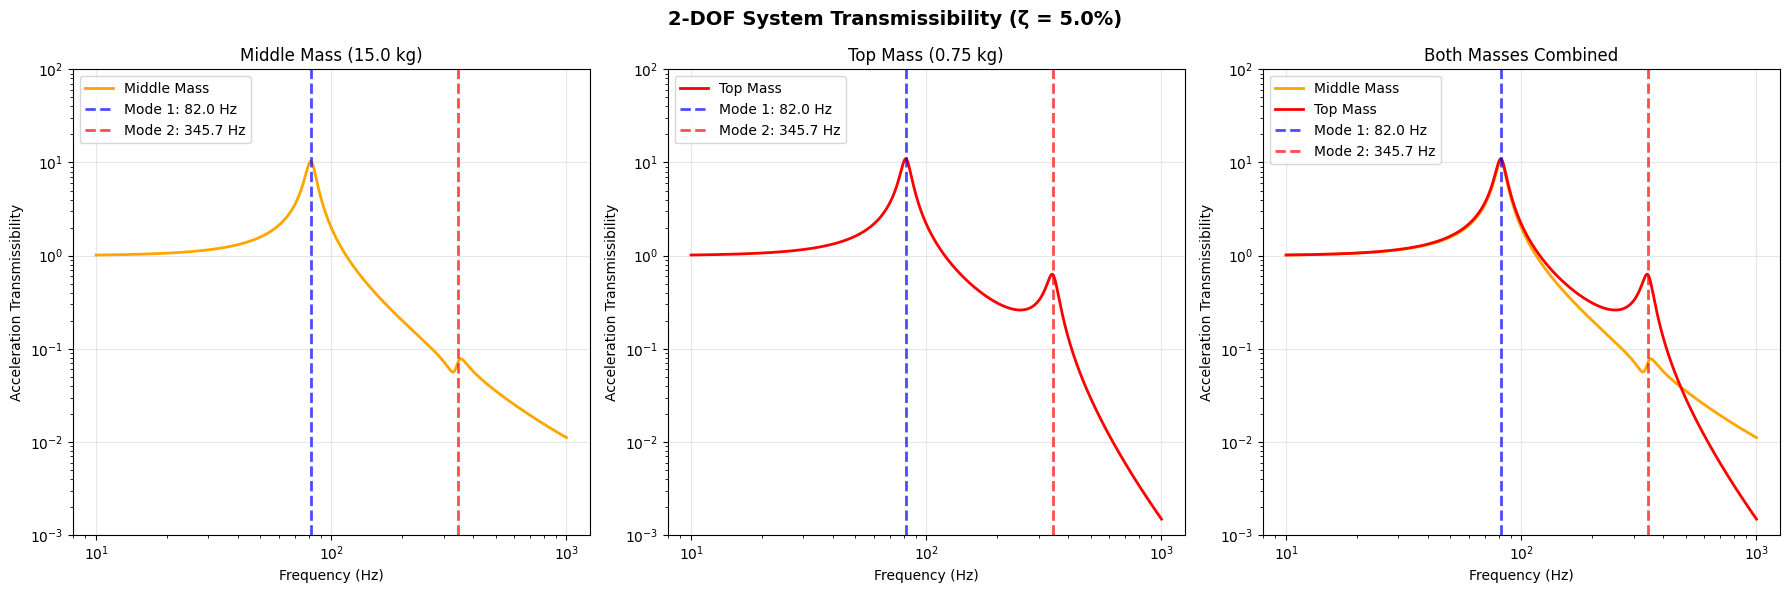

✅ 2-DOF analysis completed


In [14]:
# =============================================================================
# 2-DOF SYSTEM ANALYSIS
# =============================================================================

# Create 2-DOF system (middle mass = m1, top mass = m2)
tdof = TDOF_System(m_middle, k_middle, c_middle, m_top, k_top, c_top)

print("2-DOF System Properties:")
print(f"  Mass 1 (middle): {tdof.m1:.1f} kg")
print(f"  Mass 2 (top):    {tdof.m2:.2f} kg")
print(f"  Spring 1: {tdof.k1:.2e} N/m")
print(f"  Spring 2: {tdof.k2:.2e} N/m")
print(f"  Damper 1: {tdof.c1:.1f} N⋅s/m")
print(f"  Damper 2: {tdof.c2:.1f} N⋅s/m")

print(f"\nModal Properties:")
print(f"  Mode 1: {tdof.fn[0]:.2f} Hz")
print(f"  Mode 2: {tdof.fn[1]:.2f} Hz")
print(f"  Frequency ratio: {tdof.fn[1]/tdof.fn[0]:.3f} ({np.log2(tdof.fn[1]/tdof.fn[0]):.2f} octaves)")

print(f"\nMode Shapes:")
print(f"  Mode 1: [{tdof.mode_shapes[0,0]:+.3f}, {tdof.mode_shapes[1,0]:+.3f}]")
print(f"  Mode 2: [{tdof.mode_shapes[0,1]:+.3f}, {tdof.mode_shapes[1,1]:+.3f}]")

# Calculate transmissibility
tdof_trans_m1, tdof_trans_m2 = tdof.transmissibility(freq_range)

# Find peak transmissibilities
peak_m1_idx = np.argmax(tdof_trans_m1)
peak_m1_freq = freq_range[peak_m1_idx]
peak_m1_value = tdof_trans_m1[peak_m1_idx]

peak_m2_idx = np.argmax(tdof_trans_m2)
peak_m2_freq = freq_range[peak_m2_idx]
peak_m2_value = tdof_trans_m2[peak_m2_idx]

print(f"\n2-DOF Transmissibility:")
print(f"  Middle mass peak: {peak_m1_value:.2f} at {peak_m1_freq:.1f} Hz")
print(f"  Top mass peak:    {peak_m2_value:.2f} at {peak_m2_freq:.1f} Hz")

# Plot 2-DOF transmissibility
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Individual plots
axes[0].loglog(freq_range, tdof_trans_m1, 'orange', linewidth=2, label='Middle Mass')
axes[0].axvline(tdof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {tdof.fn[0]:.1f} Hz')
axes[0].axvline(tdof.fn[1], color='red', linestyle='--', alpha=0.7, label=f'Mode 2: {tdof.fn[1]:.1f} Hz')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Acceleration Transmissibility')
axes[0].set_title(f'Middle Mass ({m_middle:.1f} kg)')
axes[0].legend()
axes[0].set_ylim([0.001, 100])

axes[1].loglog(freq_range, tdof_trans_m2, 'red', linewidth=2, label='Top Mass')
axes[1].axvline(tdof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {tdof.fn[0]:.1f} Hz')
axes[1].axvline(tdof.fn[1], color='red', linestyle='--', alpha=0.7, label=f'Mode 2: {tdof.fn[1]:.1f} Hz')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Acceleration Transmissibility')
axes[1].set_title(f'Top Mass ({m_top:.2f} kg)')
axes[1].legend()
axes[1].set_ylim([0.001, 100])

# Combined plot
axes[2].loglog(freq_range, tdof_trans_m1, 'orange', linewidth=2, label='Middle Mass')
axes[2].loglog(freq_range, tdof_trans_m2, 'red', linewidth=2, label='Top Mass')
axes[2].axvline(tdof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {tdof.fn[0]:.1f} Hz')
axes[2].axvline(tdof.fn[1], color='red', linestyle='--', alpha=0.7, label=f'Mode 2: {tdof.fn[1]:.1f} Hz')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Acceleration Transmissibility')
axes[2].set_title('Both Masses Combined')
axes[2].legend()
axes[2].set_ylim([0.001, 100])

plt.suptitle(f'2-DOF System Transmissibility (ζ = {damping_percent:.1f}%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ 2-DOF analysis completed")

## 3-DOF System Analysis

Three degree of freedom system using all masses: lowest, middle, and top connected to base.

3-DOF System Properties:
  Mass 1 (lowest): 300 kg
  Mass 2 (middle): 15.0 kg
  Mass 3 (top):    0.75 kg
  Spring 1: 2.09e+07 N/m
  Spring 2: 4.19e+06 N/m
  Spring 3: 3.36e+06 N/m
  Damper 1: 7918.3 N⋅s/m
  Damper 2: 792.8 N⋅s/m
  Damper 3: 158.7 N⋅s/m

Modal Properties:
  Mode 1: 40.62 Hz
  Mode 2: 84.77 Hz
  Mode 3: 345.70 Hz

Frequency Ratios:
  f2/f1: 2.087 (1.06 octaves)
  f3/f2: 4.078 (2.03 octaves)
  f3/f1: 8.511 (3.09 octaves)

Mode Shapes:
  Mode 1: [+0.468, +0.620, +0.629]
  Mode 2: [-0.048, +0.683, +0.729]
  Mode 3: [+0.000, -0.053, +0.999]

3-DOF Transmissibility:
  Lowest mass peak: 10.29 at 40.5 Hz
  Middle mass peak: 13.60 at 40.6 Hz
  Top mass peak:    13.80 at 40.6 Hz


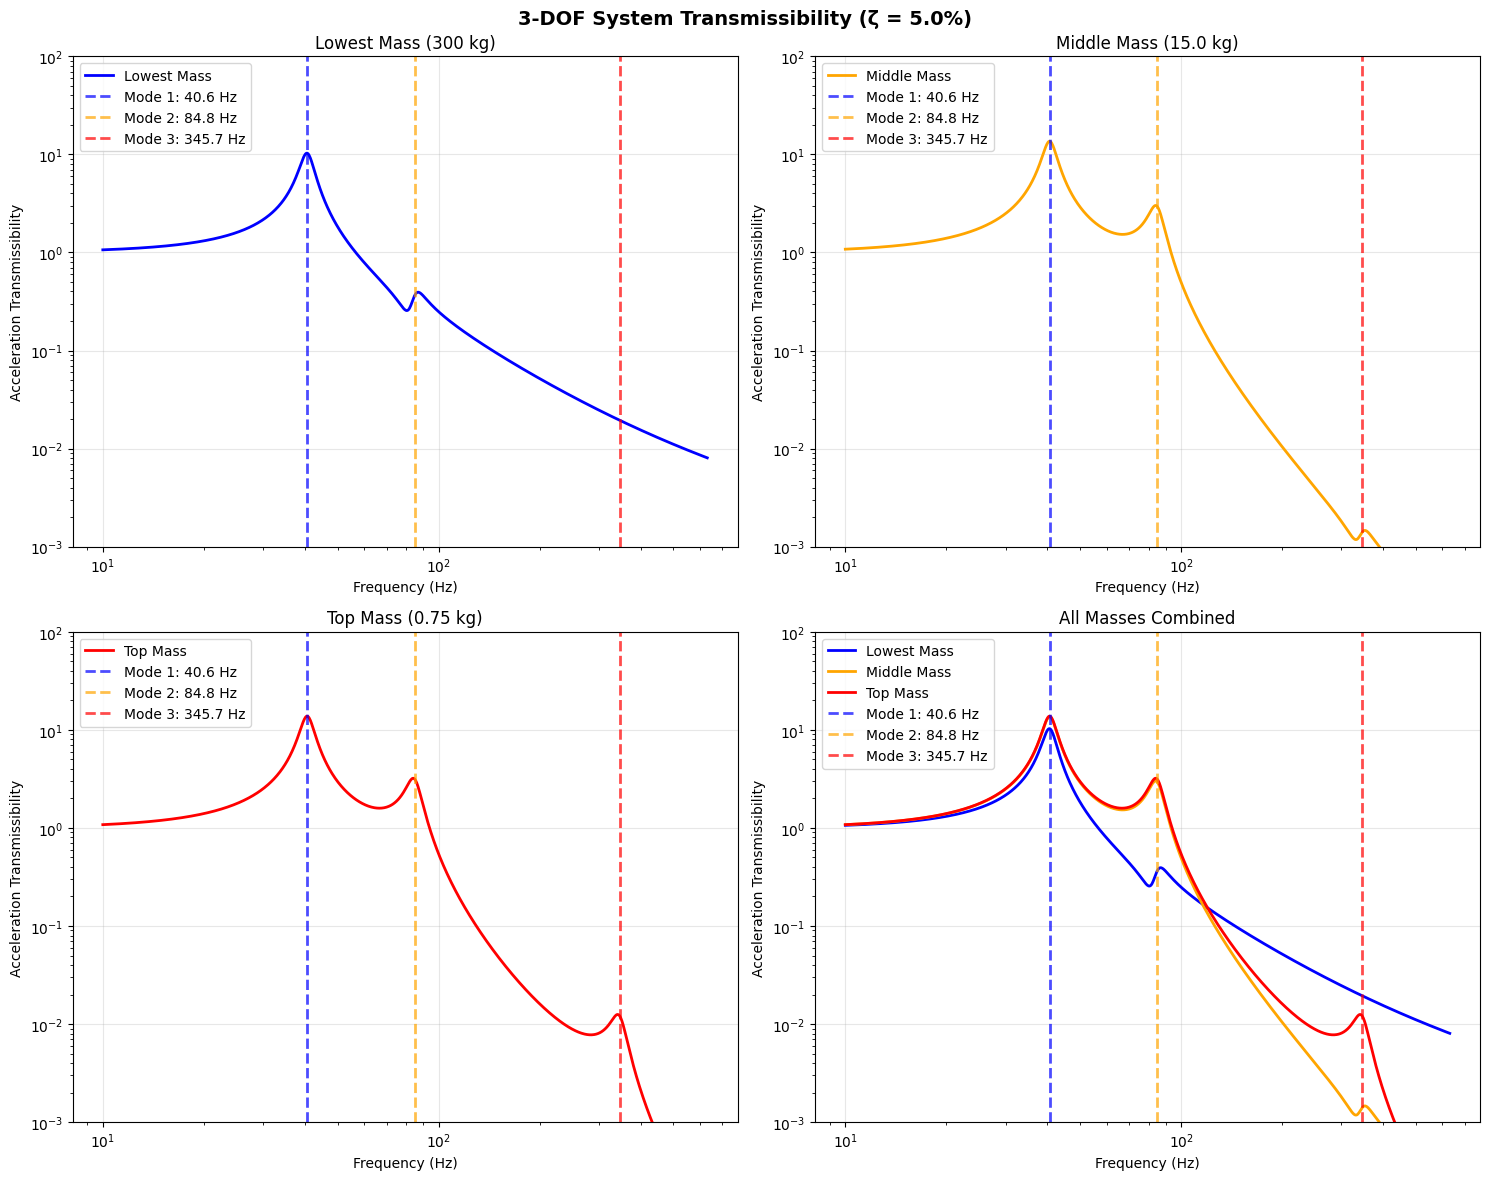

✅ 3-DOF analysis completed


In [6]:
# =============================================================================
# 3-DOF SYSTEM ANALYSIS
# =============================================================================

# Create 3-DOF system (lowest = m1, middle = m2, top = m3)
threedof = THREEDOF_System(m_lowest, k_lowest, c_lowest, 
                          m_middle, k_middle, c_middle,
                          m_top, k_top, c_top)

print("3-DOF System Properties:")
print(f"  Mass 1 (lowest): {threedof.m1:.0f} kg")
print(f"  Mass 2 (middle): {threedof.m2:.1f} kg")
print(f"  Mass 3 (top):    {threedof.m3:.2f} kg")
print(f"  Spring 1: {threedof.k1:.2e} N/m")
print(f"  Spring 2: {threedof.k2:.2e} N/m")
print(f"  Spring 3: {threedof.k3:.2e} N/m")
print(f"  Damper 1: {threedof.c1:.1f} N⋅s/m")
print(f"  Damper 2: {threedof.c2:.1f} N⋅s/m")
print(f"  Damper 3: {threedof.c3:.1f} N⋅s/m")

print(f"\nModal Properties:")
print(f"  Mode 1: {threedof.fn[0]:.2f} Hz")
print(f"  Mode 2: {threedof.fn[1]:.2f} Hz")
print(f"  Mode 3: {threedof.fn[2]:.2f} Hz")

print(f"\nFrequency Ratios:")
print(f"  f2/f1: {threedof.fn[1]/threedof.fn[0]:.3f} ({np.log2(threedof.fn[1]/threedof.fn[0]):.2f} octaves)")
print(f"  f3/f2: {threedof.fn[2]/threedof.fn[1]:.3f} ({np.log2(threedof.fn[2]/threedof.fn[1]):.2f} octaves)")
print(f"  f3/f1: {threedof.fn[2]/threedof.fn[0]:.3f} ({np.log2(threedof.fn[2]/threedof.fn[0]):.2f} octaves)")

print(f"\nMode Shapes:")
for i in range(3):
    print(f"  Mode {i+1}: [{threedof.mode_shapes[0,i]:+.3f}, {threedof.mode_shapes[1,i]:+.3f}, {threedof.mode_shapes[2,i]:+.3f}]")

# Calculate transmissibility
freq_range_3dof = np.logspace(1, 2.8, 1000)  # Extended range for 3-DOF
threedof_trans_m1, threedof_trans_m2, threedof_trans_m3 = threedof.transmissibility(freq_range_3dof)

# Find peak transmissibilities
peak_3m1_idx = np.argmax(threedof_trans_m1)
peak_3m1_freq = freq_range_3dof[peak_3m1_idx]
peak_3m1_value = threedof_trans_m1[peak_3m1_idx]

peak_3m2_idx = np.argmax(threedof_trans_m2)
peak_3m2_freq = freq_range_3dof[peak_3m2_idx]
peak_3m2_value = threedof_trans_m2[peak_3m2_idx]

peak_3m3_idx = np.argmax(threedof_trans_m3)
peak_3m3_freq = freq_range_3dof[peak_3m3_idx]
peak_3m3_value = threedof_trans_m3[peak_3m3_idx]

print(f"\n3-DOF Transmissibility:")
print(f"  Lowest mass peak: {peak_3m1_value:.2f} at {peak_3m1_freq:.1f} Hz")
print(f"  Middle mass peak: {peak_3m2_value:.2f} at {peak_3m2_freq:.1f} Hz")
print(f"  Top mass peak:    {peak_3m3_value:.2f} at {peak_3m3_freq:.1f} Hz")

# Plot 3-DOF transmissibility
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual plots
axes[0,0].loglog(freq_range_3dof, threedof_trans_m1, 'blue', linewidth=2, label='Lowest Mass')
axes[0,0].axvline(threedof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {threedof.fn[0]:.1f} Hz')
axes[0,0].axvline(threedof.fn[1], color='orange', linestyle='--', alpha=0.7, label=f'Mode 2: {threedof.fn[1]:.1f} Hz')
axes[0,0].axvline(threedof.fn[2], color='red', linestyle='--', alpha=0.7, label=f'Mode 3: {threedof.fn[2]:.1f} Hz')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlabel('Frequency (Hz)')
axes[0,0].set_ylabel('Acceleration Transmissibility')
axes[0,0].set_title(f'Lowest Mass ({m_lowest:.0f} kg)')
axes[0,0].legend()
axes[0,0].set_ylim([0.001, 100])

axes[0,1].loglog(freq_range_3dof, threedof_trans_m2, 'orange', linewidth=2, label='Middle Mass')
axes[0,1].axvline(threedof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {threedof.fn[0]:.1f} Hz')
axes[0,1].axvline(threedof.fn[1], color='orange', linestyle='--', alpha=0.7, label=f'Mode 2: {threedof.fn[1]:.1f} Hz')
axes[0,1].axvline(threedof.fn[2], color='red', linestyle='--', alpha=0.7, label=f'Mode 3: {threedof.fn[2]:.1f} Hz')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Acceleration Transmissibility')
axes[0,1].set_title(f'Middle Mass ({m_middle:.1f} kg)')
axes[0,1].legend()
axes[0,1].set_ylim([0.001, 100])

axes[1,0].loglog(freq_range_3dof, threedof_trans_m3, 'red', linewidth=2, label='Top Mass')
axes[1,0].axvline(threedof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {threedof.fn[0]:.1f} Hz')
axes[1,0].axvline(threedof.fn[1], color='orange', linestyle='--', alpha=0.7, label=f'Mode 2: {threedof.fn[1]:.1f} Hz')
axes[1,0].axvline(threedof.fn[2], color='red', linestyle='--', alpha=0.7, label=f'Mode 3: {threedof.fn[2]:.1f} Hz')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlabel('Frequency (Hz)')
axes[1,0].set_ylabel('Acceleration Transmissibility')
axes[1,0].set_title(f'Top Mass ({m_top:.2f} kg)')
axes[1,0].legend()
axes[1,0].set_ylim([0.001, 100])

# Combined plot
axes[1,1].loglog(freq_range_3dof, threedof_trans_m1, 'blue', linewidth=2, label='Lowest Mass')
axes[1,1].loglog(freq_range_3dof, threedof_trans_m2, 'orange', linewidth=2, label='Middle Mass')
axes[1,1].loglog(freq_range_3dof, threedof_trans_m3, 'red', linewidth=2, label='Top Mass')
axes[1,1].axvline(threedof.fn[0], color='blue', linestyle='--', alpha=0.7, label=f'Mode 1: {threedof.fn[0]:.1f} Hz')
axes[1,1].axvline(threedof.fn[1], color='orange', linestyle='--', alpha=0.7, label=f'Mode 2: {threedof.fn[1]:.1f} Hz')
axes[1,1].axvline(threedof.fn[2], color='red', linestyle='--', alpha=0.7, label=f'Mode 3: {threedof.fn[2]:.1f} Hz')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Acceleration Transmissibility')
axes[1,1].set_title('All Masses Combined')
axes[1,1].legend()
axes[1,1].set_ylim([0.001, 100])

plt.suptitle(f'3-DOF System Transmissibility (ζ = {damping_percent:.1f}%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ 3-DOF analysis completed")

## Overall System Comparison

Direct comparison of all MDOF systems showing the evolution from SDOF to 3-DOF behavior.

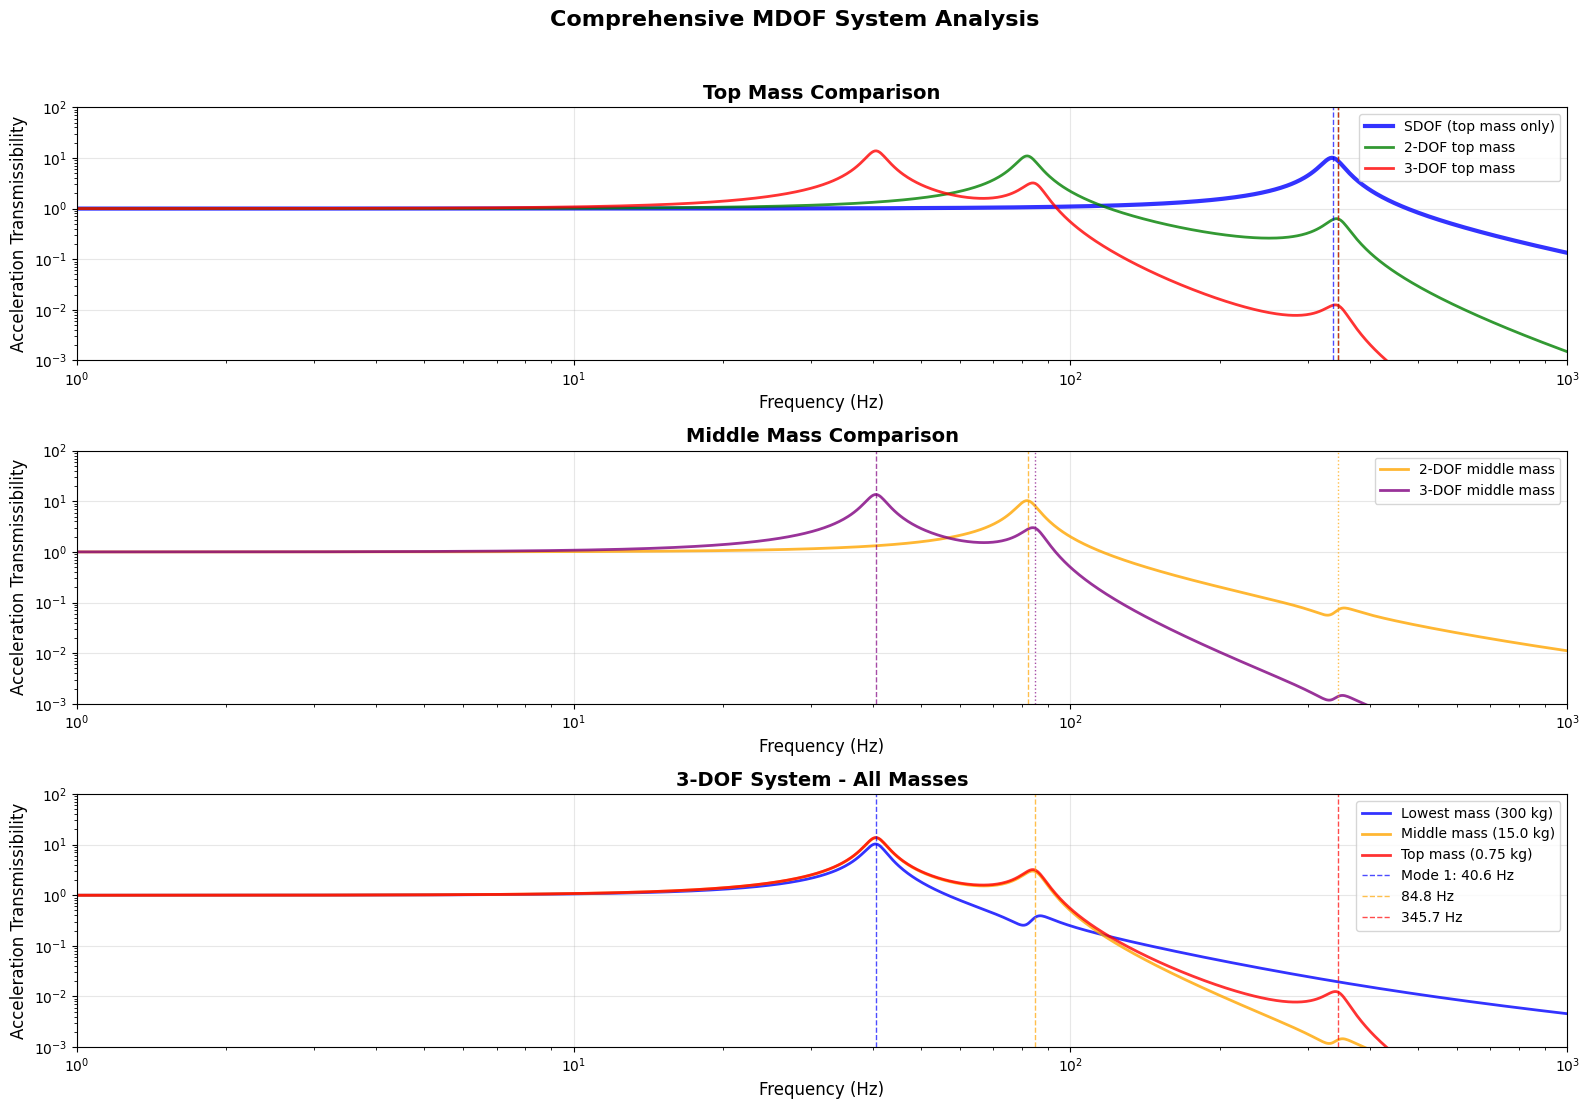

                    FINAL NUMERICAL SUMMARY

🎯 RESONANT FREQUENCY COMPARISON:
   SDOF (top only):     336.87 Hz
   2-DOF Mode 1:        81.97 Hz
   2-DOF Mode 2:        345.70 Hz
   3-DOF Mode 1:        40.62 Hz
   3-DOF Mode 2:        84.77 Hz
   3-DOF Mode 3:        345.70 Hz

📈 PEAK TRANSMISSIBILITY VALUES:
   SDOF:                10.05
   2-DOF middle mass:   10.31
   2-DOF top mass:      10.96
   3-DOF lowest mass:   10.29
   3-DOF middle mass:   13.60
   3-DOF top mass:      13.80

🔧 DESIGN INSIGHTS:
   • Adding masses creates multiple resonances
   • Peak transmissibility generally increases with complexity
   • System coupling shifts natural frequencies
   • Mass ratios determine modal characteristics
   • All systems provide isolation above resonant frequencies

✅ Analysis completed successfully!


In [7]:
# =============================================================================
# OVERALL SYSTEM COMPARISON PLOTS
# =============================================================================

# Create comprehensive comparison plot with proper formatting
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Set consistent frequency range for fair comparison
freq_comp = np.logspace(0, 3, 1000)  # 1 Hz to 1000 Hz

# Calculate transmissibilities for comparison
sdof_comp = sdof.transmissibility(freq_comp)
tdof_m1_comp, tdof_m2_comp = tdof.transmissibility(freq_comp)
threedof_m1_comp, threedof_m2_comp, threedof_m3_comp = threedof.transmissibility(freq_comp)

# Plot 1: SDOF vs Top mass in 2-DOF and 3-DOF
axes[0].loglog(freq_comp, sdof_comp, 'blue', linewidth=3, label='SDOF (top mass only)', alpha=0.8)
axes[0].loglog(freq_comp, tdof_m2_comp, 'green', linewidth=2, label='2-DOF top mass', alpha=0.8)
axes[0].loglog(freq_comp, threedof_m3_comp, 'red', linewidth=2, label='3-DOF top mass', alpha=0.8)

# Add natural frequency indicators
axes[0].axvline(sdof.fn, color='blue', linestyle='--', alpha=0.7, linewidth=1)
axes[0].axvline(tdof.fn[1], color='green', linestyle='--', alpha=0.7, linewidth=1)
axes[0].axvline(threedof.fn[2], color='red', linestyle='--', alpha=0.7, linewidth=1)

axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
axes[0].set_ylabel('Acceleration Transmissibility', fontsize=12)
axes[0].set_title('Top Mass Comparison', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].set_ylim([0.001, 100])
axes[0].set_xlim([1, 1000])

# Plot 2: All systems - Middle masses
axes[1].loglog(freq_comp, tdof_m1_comp, 'orange', linewidth=2, label='2-DOF middle mass', alpha=0.8)
axes[1].loglog(freq_comp, threedof_m2_comp, 'purple', linewidth=2, label='3-DOF middle mass', alpha=0.8)

# Add natural frequency indicators
axes[1].axvline(tdof.fn[0], color='orange', linestyle='--', alpha=0.7, linewidth=1)
axes[1].axvline(tdof.fn[1], color='orange', linestyle=':', alpha=0.7, linewidth=1)
axes[1].axvline(threedof.fn[0], color='purple', linestyle='--', alpha=0.7, linewidth=1)
axes[1].axvline(threedof.fn[1], color='purple', linestyle=':', alpha=0.7, linewidth=1)

axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)', fontsize=12)
axes[1].set_ylabel('Acceleration Transmissibility', fontsize=12)
axes[1].set_title('Middle Mass Comparison', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].set_ylim([0.001, 100])
axes[1].set_xlim([1, 1000])

# Plot 3: 3-DOF system - All masses
axes[2].loglog(freq_comp, threedof_m1_comp, 'blue', linewidth=2, label=f'Lowest mass ({m_lowest:.0f} kg)', alpha=0.8)
axes[2].loglog(freq_comp, threedof_m2_comp, 'orange', linewidth=2, label=f'Middle mass ({m_middle:.1f} kg)', alpha=0.8)
axes[2].loglog(freq_comp, threedof_m3_comp, 'red', linewidth=2, label=f'Top mass ({m_top:.2f} kg)', alpha=0.8)

# Add modal frequency indicators
for i, (freq, color) in enumerate(zip(threedof.fn, ['blue', 'orange', 'red'])):
    axes[2].axvline(freq, color=color, linestyle='--', alpha=0.7, linewidth=1,
                     label=f'Mode {i+1}: {freq:.1f} Hz' if i == 0 else f'{freq:.1f} Hz')

axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Frequency (Hz)', fontsize=12)
axes[2].set_ylabel('Acceleration Transmissibility', fontsize=12)
axes[2].set_title('3-DOF System - All Masses', fontweight='bold', fontsize=14)
axes[2].legend(fontsize=10, loc='upper right')
axes[2].set_ylim([0.001, 100])
axes[2].set_xlim([1, 1000])

plt.suptitle('Comprehensive MDOF System Analysis', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

# Print final numerical summary
print("="*80)
print("                    FINAL NUMERICAL SUMMARY")
print("="*80)

print(f"\n🎯 RESONANT FREQUENCY COMPARISON:")
print(f"   SDOF (top only):     {sdof.fn:.2f} Hz")
print(f"   2-DOF Mode 1:        {tdof.fn[0]:.2f} Hz")
print(f"   2-DOF Mode 2:        {tdof.fn[1]:.2f} Hz")
print(f"   3-DOF Mode 1:        {threedof.fn[0]:.2f} Hz")
print(f"   3-DOF Mode 2:        {threedof.fn[1]:.2f} Hz")
print(f"   3-DOF Mode 3:        {threedof.fn[2]:.2f} Hz")

print(f"\n📈 PEAK TRANSMISSIBILITY VALUES:")
print(f"   SDOF:                {peak_value:.2f}")
print(f"   2-DOF middle mass:   {peak_m1_value:.2f}")
print(f"   2-DOF top mass:      {peak_m2_value:.2f}")
print(f"   3-DOF lowest mass:   {peak_3m1_value:.2f}")
print(f"   3-DOF middle mass:   {peak_3m2_value:.2f}")
print(f"   3-DOF top mass:      {peak_3m3_value:.2f}")

print(f"\n🔧 DESIGN INSIGHTS:")
print(f"   • Adding masses creates multiple resonances")
print(f"   • Peak transmissibility generally increases with complexity")
print(f"   • System coupling shifts natural frequencies")
print(f"   • Mass ratios determine modal characteristics")
print(f"   • All systems provide isolation above resonant frequencies")

print(f"\n✅ Analysis completed successfully!")
print("="*80)

## Physics of Modal Coupling

Visualization of why the top mass doesn't resonate at its uncoupled frequency when coupled to other masses.

🔬 PHYSICS OF MODAL COUPLING

📊 FREQUENCY COMPARISON:
   Uncoupled Frequencies:
     Top mass (isolated):    336.87 Hz
     Middle mass (isolated): 84.12 Hz
     Lowest mass (isolated): 42.01 Hz

   3-DOF Coupled Modal Frequencies:
     Mode 1: 40.62 Hz
     Mode 2: 84.77 Hz
     Mode 3: 345.70 Hz

   🎯 KEY OBSERVATION:
     Top mass uncoupled:  336.87 Hz
     Mode 3 (coupled):    345.70 Hz
     Frequency shift:     +8.84 Hz


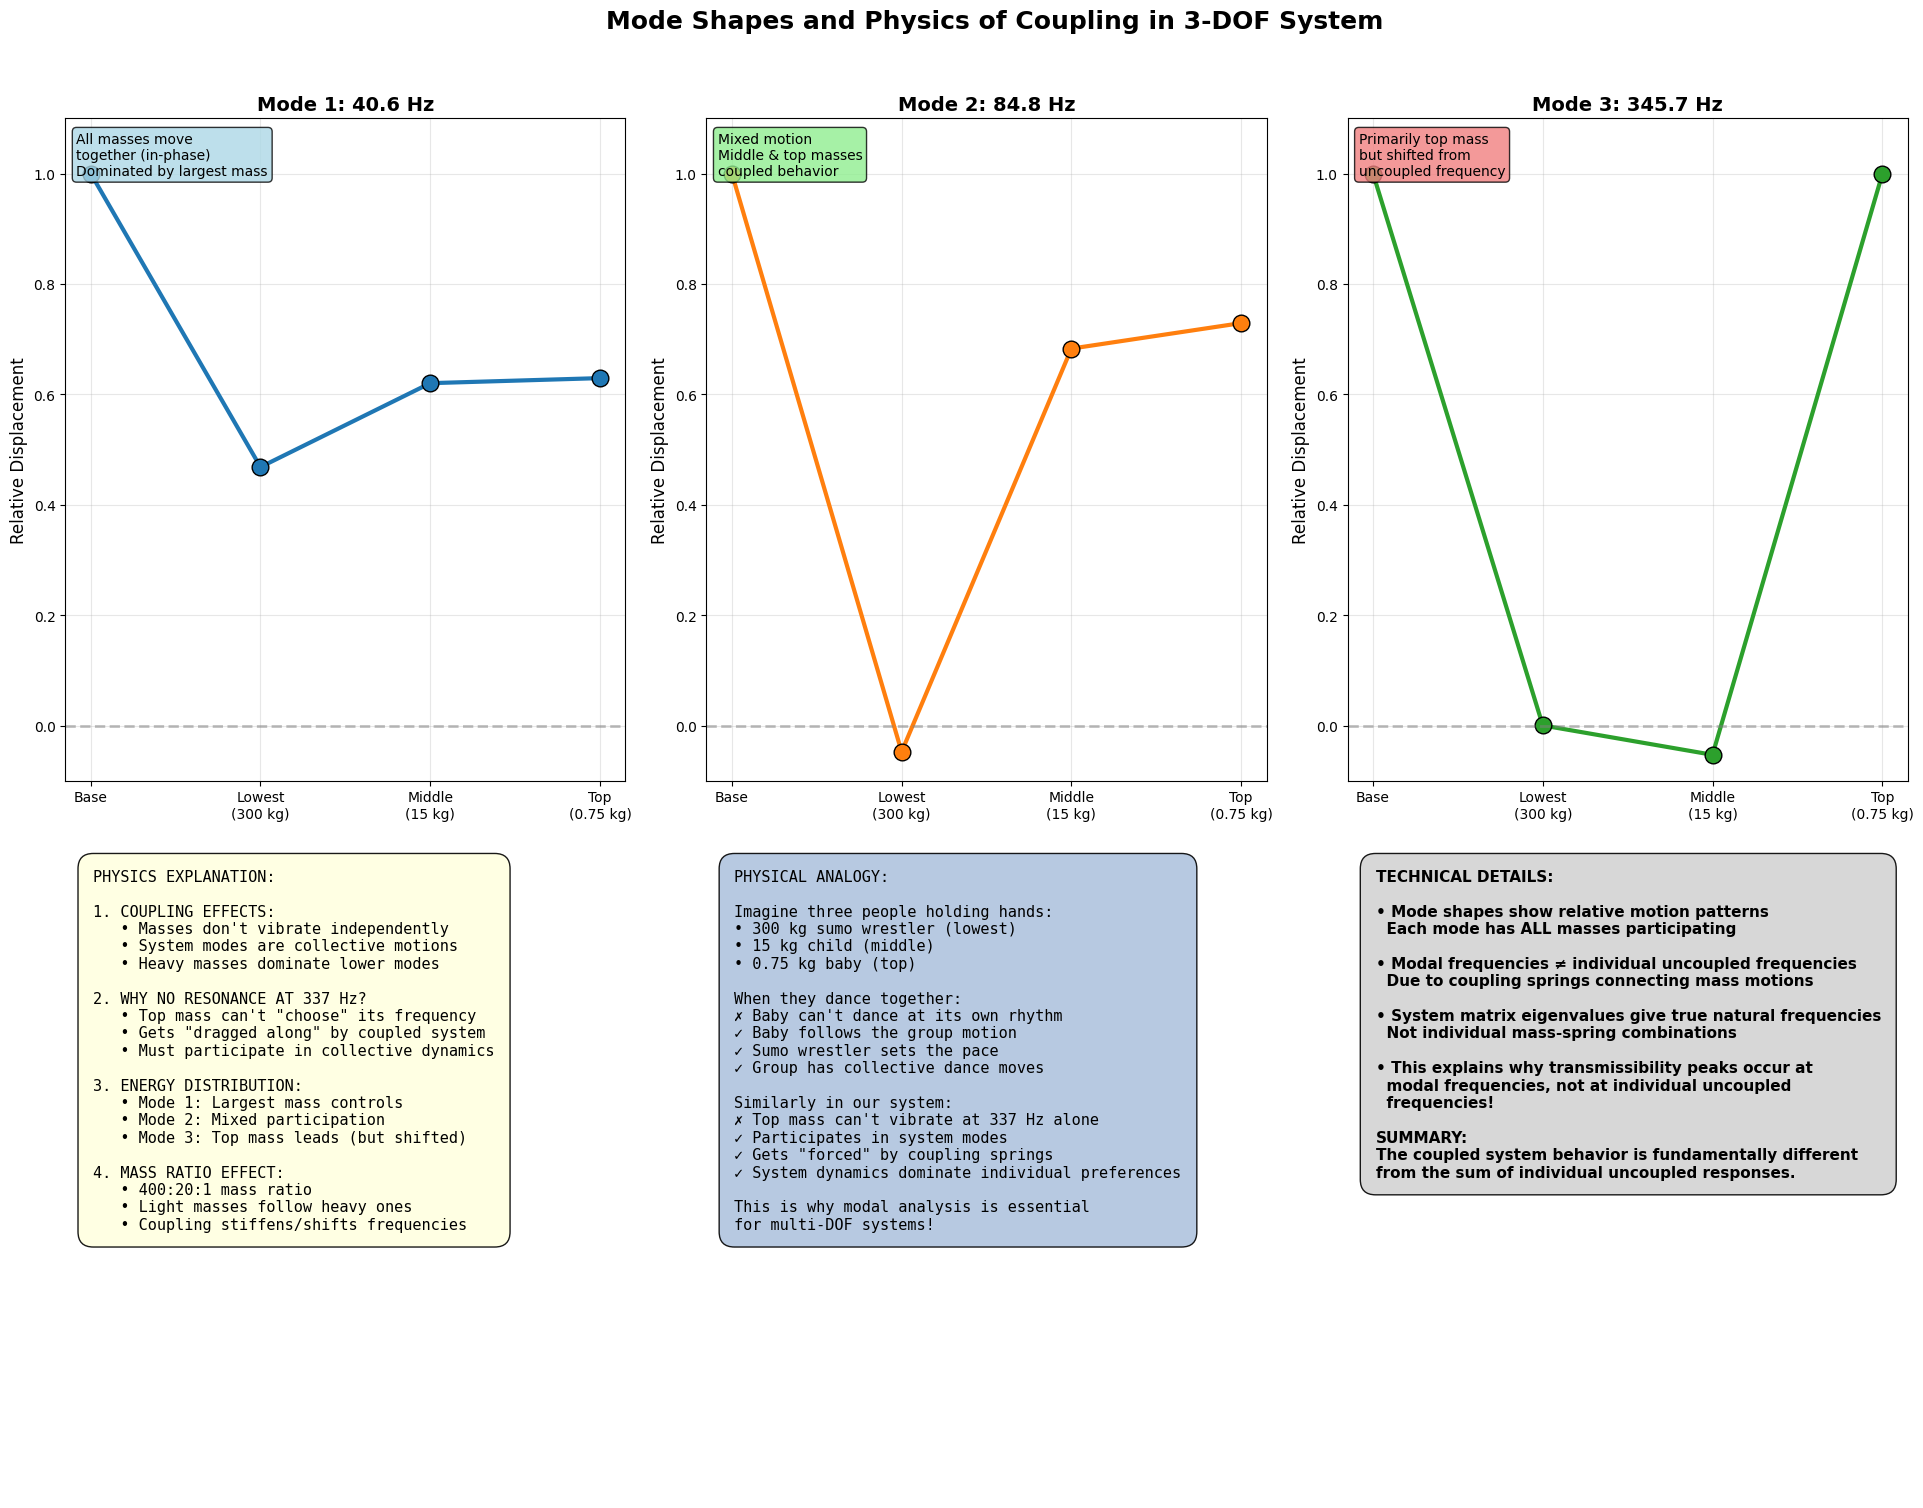


🔧 SUMMARY:
   • Mode shapes show relative motion patterns
   • Each mode has ALL masses participating
   • Modal frequencies ≠ individual uncoupled frequencies
   • Coupling springs connect mass motions
   • System matrix eigenvalues give true natural frequencies

✅ This explains why transmissibility peaks occur at modal frequencies,
   not at individual uncoupled frequencies!


In [8]:
# =============================================================================
# MODE SHAPE VISUALIZATION AND PHYSICS EXPLANATION
# =============================================================================

def plot_mode_shapes_and_physics():
    """Visualize mode shapes and explain coupling physics."""
    
    print("🔬 PHYSICS OF MODAL COUPLING")
    print("="*60)
    
    # Compare uncoupled vs coupled frequencies
    print(f"\n📊 FREQUENCY COMPARISON:")
    print(f"   Uncoupled Frequencies:")
    print(f"     Top mass (isolated):    {fn_top_uncoupled:.2f} Hz")
    print(f"     Middle mass (isolated): {fn_middle_uncoupled:.2f} Hz") 
    print(f"     Lowest mass (isolated): {fn_lowest_uncoupled:.2f} Hz")
    
    print(f"\n   3-DOF Coupled Modal Frequencies:")
    print(f"     Mode 1: {threedof.fn[0]:.2f} Hz")
    print(f"     Mode 2: {threedof.fn[1]:.2f} Hz")
    print(f"     Mode 3: {threedof.fn[2]:.2f} Hz")
    
    # Show frequency shifts
    print(f"\n   🎯 KEY OBSERVATION:")
    print(f"     Top mass uncoupled:  {fn_top_uncoupled:.2f} Hz")
    print(f"     Mode 3 (coupled):    {threedof.fn[2]:.2f} Hz")
    print(f"     Frequency shift:     {threedof.fn[2] - fn_top_uncoupled:+.2f} Hz")
    
    # Create mode shape visualization with corrected layout
    fig = plt.figure(figsize=(20, 16))
    
    # Define positions for masses (visual representation)
    positions = np.array([0, 1, 2, 3])  # Base, lowest, middle, top
    mass_labels = ['Base', 'Lowest\n(300 kg)', 'Middle\n(15 kg)', 'Top\n(0.75 kg)']
    
    # Plot each mode shape in top row
    for mode in range(3):
        ax = plt.subplot(2, 3, mode + 1)  # Top row: positions 1, 2, 3
        
        # Add base displacement (always 1 for base excitation)
        mode_shape = np.array([1.0, threedof.mode_shapes[0, mode], 
                              threedof.mode_shapes[1, mode], 
                              threedof.mode_shapes[2, mode]])
        
        ax.plot(positions, mode_shape, 'o-', linewidth=3, markersize=12, 
                color=f'C{mode}', markerfacecolor=f'C{mode}', markeredgecolor='black', markeredgewidth=1)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(positions)
        ax.set_xticklabels(mass_labels, rotation=0, fontsize=10)
        ax.set_ylabel('Relative Displacement', fontsize=12)
        ax.set_title(f'Mode {mode+1}: {threedof.fn[mode]:.1f} Hz', fontweight='bold', fontsize=14)
        ax.set_ylim([-0.1, 1.1])
        
        # Add annotations about mass participation
        if mode == 0:  # Mode 1
            ax.text(0.02, 0.98, 'All masses move\ntogether (in-phase)\nDominated by largest mass', 
                   transform=ax.transAxes, fontsize=10, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        elif mode == 1:  # Mode 2
            ax.text(0.02, 0.98, 'Mixed motion\nMiddle & top masses\ncoupled behavior', 
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        else:  # Mode 3
            ax.text(0.02, 0.98, 'Primarily top mass\nbut shifted from\nuncoupled frequency', 
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Physics explanation in bottom left
    ax_physics = plt.subplot(2, 3, 4)  # Bottom left
    ax_physics.axis('off')
    physics_text = """PHYSICS EXPLANATION:

1. COUPLING EFFECTS:
   • Masses don't vibrate independently
   • System modes are collective motions
   • Heavy masses dominate lower modes

2. WHY NO RESONANCE AT 337 Hz?
   • Top mass can't "choose" its frequency
   • Gets "dragged along" by coupled system
   • Must participate in collective dynamics

3. ENERGY DISTRIBUTION:
   • Mode 1: Largest mass controls
   • Mode 2: Mixed participation  
   • Mode 3: Top mass leads (but shifted)

4. MASS RATIO EFFECT:
   • 400:20:1 mass ratio
   • Light masses follow heavy ones
   • Coupling stiffens/shifts frequencies"""
    
    ax_physics.text(0.05, 0.95, physics_text, transform=ax_physics.transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.9))
    
    # Physical analogy in bottom middle
    ax_analogy = plt.subplot(2, 3, 5)  # Bottom middle
    ax_analogy.axis('off')
    analogy_text = """PHYSICAL ANALOGY:

Imagine three people holding hands:
• 300 kg sumo wrestler (lowest)
• 15 kg child (middle)  
• 0.75 kg baby (top)

When they dance together:
✗ Baby can't dance at its own rhythm
✓ Baby follows the group motion
✓ Sumo wrestler sets the pace
✓ Group has collective dance moves

Similarly in our system:
✗ Top mass can't vibrate at 337 Hz alone
✓ Participates in system modes
✓ Gets "forced" by coupling springs
✓ System dynamics dominate individual preferences

This is why modal analysis is essential
for multi-DOF systems!"""
    
    ax_analogy.text(0.05, 0.95, analogy_text, transform=ax_analogy.transAxes,
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round,pad=1', facecolor='lightsteelblue', alpha=0.9))
    
    # Technical details in bottom right
    ax_technical = plt.subplot(2, 3, 6)  # Bottom right
    ax_technical.axis('off')
    technical_text = """TECHNICAL DETAILS:

• Mode shapes show relative motion patterns
  Each mode has ALL masses participating

• Modal frequencies ≠ individual uncoupled frequencies
  Due to coupling springs connecting mass motions

• System matrix eigenvalues give true natural frequencies
  Not individual mass-spring combinations

• This explains why transmissibility peaks occur at 
  modal frequencies, not at individual uncoupled 
  frequencies!

SUMMARY:
The coupled system behavior is fundamentally different
from the sum of individual uncoupled responses."""
    
    ax_technical.text(0.05, 0.95, technical_text, transform=ax_technical.transAxes,
                     fontsize=11, verticalalignment='top', fontweight='bold',
                     bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.9))
    
    plt.suptitle('Mode Shapes and Physics of Coupling in 3-DOF System', 
                 fontsize=18, fontweight='bold', y=0.96)
    plt.tight_layout(rect=[0, 0.02, 1, 0.94])
    plt.show()
    
    # Additional summary
    print(f"\n🔧 SUMMARY:")
    print(f"   • Mode shapes show relative motion patterns")
    print(f"   • Each mode has ALL masses participating")
    print(f"   • Modal frequencies ≠ individual uncoupled frequencies") 
    print(f"   • Coupling springs connect mass motions")
    print(f"   • System matrix eigenvalues give true natural frequencies")
    
    print(f"\n✅ This explains why transmissibility peaks occur at modal frequencies,")
    print(f"   not at individual uncoupled frequencies!")

# Run the visualization
plot_mode_shapes_and_physics()

## Time Domain Analysis

### Half-Sine Input Time Response

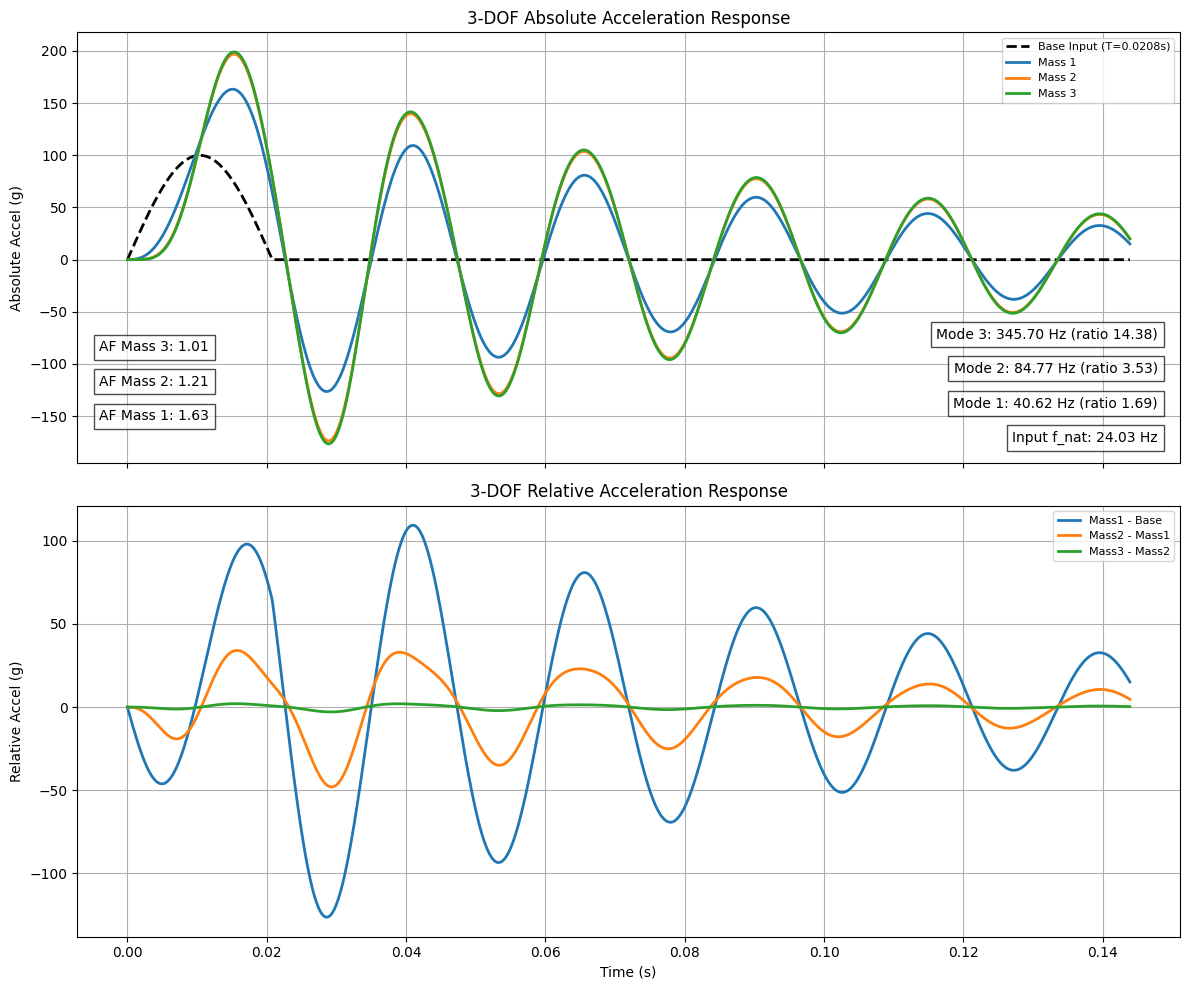

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 3-DOF Half-Sine Base Excitation Response

# Determine modal frequencies
f_mode1 = threedof.fn[0]          # lowest mode
f_mode_max = np.max(threedof.fn)  # highest mode

# Half-sine pulse parameters
peak = 100.0                     # peak acceleration (g)

# Input natural frequency (Hz) - modify as desired
f_input = f_mode1/1.69                   # input natural frequency (Hz)
T_pulse = 1.0 / (2 * f_input)    # half-sine period from input frequency

# Total duration: input pulse + ringdown cycles based on lowest mode
cycles = 5                       # number of lowest-mode cycles to display
mode_period = 1.0 / f_mode1      # period of lowest mode
t_total = T_pulse + cycles * mode_period

# Sampling rate: highest mode * factor for smoothness
sample_factor = 20               # samples per cycle of highest mode
fs = f_mode_max * sample_factor

# Time vector
t = np.linspace(0, t_total, int(t_total * fs))

# Base acceleration: half-sine during pulse, zero after
a_base = np.zeros_like(t)
mask = t <= T_pulse
a_base[mask] = peak * np.sin(np.pi * t[mask] / T_pulse)

# Compute 3-DOF time response
t_out, a_3d = time_response(threedof, t, a_base)

# Calculate amplification factors: peak absolute accel ratios
af1 = np.max(np.abs(a_3d[0])) / np.max(np.abs(a_base))
af2 = np.max(np.abs(a_3d[1])) / np.max(np.abs(a_3d[0]))
af3 = np.max(np.abs(a_3d[2])) / np.max(np.abs(a_3d[1]))

# Plot absolute and relative accelerations
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Absolute response
axs[0].plot(t, a_base, 'k--', label=f'Base Input (T={T_pulse:.4f}s)')
for idx in range(a_3d.shape[0]):
    axs[0].plot(t_out, a_3d[idx], label=f'Mass {idx+1}')
axs[0].set_ylabel('Absolute Accel (g)')
axs[0].set_title('3-DOF Absolute Acceleration Response')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].grid(True)

# Annotate amplification factors in lower-left
text_y_start = 0.1
spacing = 0.08
for idx, af in enumerate([af1, af2, af3]):
    axs[0].text(0.02, text_y_start + idx * spacing,
                f'AF Mass {idx+1}: {af:.2f}',
                transform=axs[0].transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Annotate input and mode natural frequencies in lower-right
text_x = 0.98
text_y_start_r = 0.05
freq_lines = [f'Input f_nat: {f_input:.2f} Hz'] + [
    f'Mode {j+1}: {fn:.2f} Hz (ratio {fn/f_input:.2f})' for j, fn in enumerate(threedof.fn)
]
for j, line in enumerate(freq_lines):
    axs[0].text(text_x, text_y_start_r + j * spacing,
                line, transform=axs[0].transAxes,
                ha='right', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

# Relative accelerations: mass1-base, mass2-mass1, mass3-mass2
a_rel1 = a_3d[0] - a_base
a_rel2 = a_3d[1] - a_3d[0]
a_rel3 = a_3d[2] - a_3d[1]
axs[1].plot(t_out, a_rel1, label='Mass1 - Base')
axs[1].plot(t_out, a_rel2, label='Mass2 - Mass1')
axs[1].plot(t_out, a_rel3, label='Mass3 - Mass2')
axs[1].set_ylabel('Relative Accel (g)')
axs[1].set_title('3-DOF Relative Acceleration Response')
axs[1].set_xlabel('Time (s)')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Half-Sine Amplification Factor Study

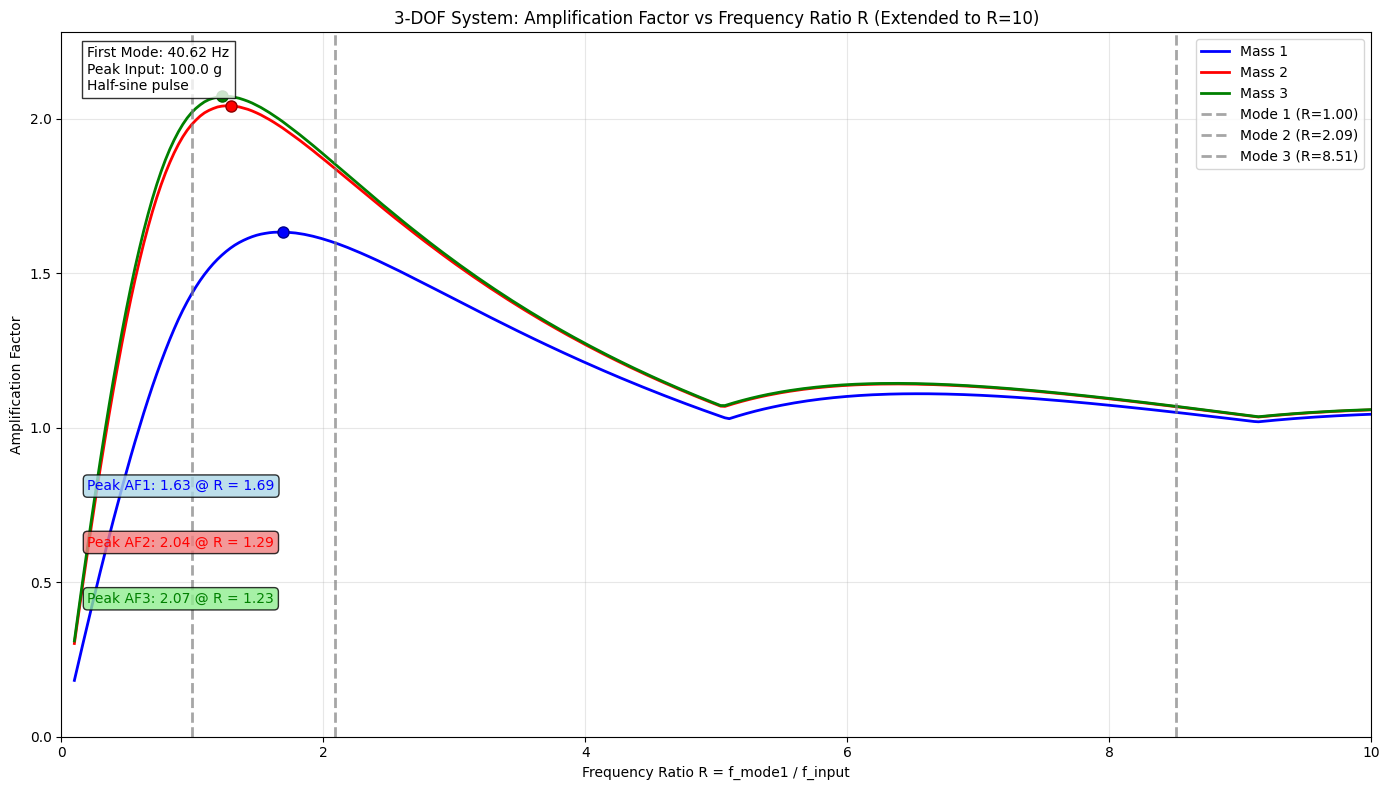

In [10]:
# Frequency Ratio (R) Study: Amplification Factor vs R
# R = f_mode1 / f_input, where R ranges from 0.1 to 10

import numpy as np
import matplotlib.pyplot as plt

# Parameters
f_mode1 = threedof.fn[0]  # first mode frequency
peak = 100.0              # peak acceleration (g)

# Define R range (0.1 to 10) and corresponding input frequencies
R_values = np.linspace(0.1, 10.0, 300)  # Extended to 10 with more points for smoothness
f_input_values = f_mode1 / R_values     # f_input = f_mode1 / R

# Storage arrays for amplification factors
AF_mass1 = np.zeros_like(R_values)
AF_mass2 = np.zeros_like(R_values)
AF_mass3 = np.zeros_like(R_values)

# Loop through each input frequency
for i, f_input in enumerate(f_input_values):
    # Half-sine pulse parameters
    T_pulse = 1.0 / (2 * f_input)
    
    # Time parameters
    cycles = 3  # reduced for speed
    mode_period = 1.0 / f_mode1
    t_total = T_pulse + cycles * mode_period
    
    # Sampling
    sample_factor = 15  # reduced for speed
    fs = np.max(threedof.fn) * sample_factor
    t = np.linspace(0, t_total, int(t_total * fs))
    
    # Base acceleration: half-sine pulse
    a_base = np.zeros_like(t)
    mask = t <= T_pulse
    a_base[mask] = peak * np.sin(np.pi * t[mask] / T_pulse)
    
    # Compute response
    t_out, a_3d = time_response(threedof, t, a_base)
    
    # Calculate amplification factors
    AF_mass1[i] = np.max(np.abs(a_3d[0])) / np.max(np.abs(a_base))
    AF_mass2[i] = np.max(np.abs(a_3d[1])) / np.max(np.abs(a_base))
    AF_mass3[i] = np.max(np.abs(a_3d[2])) / np.max(np.abs(a_base))

# Find peak amplification factors and their R values
peak_AF1_idx = np.argmax(AF_mass1)
peak_AF1_R = R_values[peak_AF1_idx]
peak_AF1_value = AF_mass1[peak_AF1_idx]

peak_AF2_idx = np.argmax(AF_mass2)
peak_AF2_R = R_values[peak_AF2_idx]
peak_AF2_value = AF_mass2[peak_AF2_idx]

peak_AF3_idx = np.argmax(AF_mass3)
peak_AF3_R = R_values[peak_AF3_idx]
peak_AF3_value = AF_mass3[peak_AF3_idx]

# Plot amplification factors vs frequency ratio R
plt.figure(figsize=(14, 8))
plt.plot(R_values, AF_mass1, 'b-', label='Mass 1', linewidth=2)
plt.plot(R_values, AF_mass2, 'r-', label='Mass 2', linewidth=2)
plt.plot(R_values, AF_mass3, 'g-', label='Mass 3', linewidth=2)

# Mark peak points on each curve
plt.plot(peak_AF1_R, peak_AF1_value, 'bo', markersize=8, markerfacecolor='blue', markeredgecolor='darkblue')
plt.plot(peak_AF2_R, peak_AF2_value, 'ro', markersize=8, markerfacecolor='red', markeredgecolor='darkred')
plt.plot(peak_AF3_R, peak_AF3_value, 'go', markersize=8, markerfacecolor='green', markeredgecolor='darkgreen')

# Add vertical lines at mode ratios
for j, fn in enumerate(threedof.fn):
    R_mode = fn / f_mode1
    if R_mode <= 10:  # Only show lines within the plot range
        plt.axvline(R_mode, color='gray', linestyle='--', alpha=0.7, 
                    label=f'Mode {j+1} (R={R_mode:.2f})' if j < 3 else None)

plt.xlabel('Frequency Ratio R = f_mode1 / f_input')
plt.ylabel('Amplification Factor')
plt.title('3-DOF System: Amplification Factor vs Frequency Ratio R (Extended to R=10)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 10)  # Extended x-axis to 10
plt.ylim(0, np.max([AF_mass1, AF_mass2, AF_mass3]) * 1.1)

# Add peak annotation boxes in lower left (no arrows)
peak_box_x = 0.02  # x position in axes coordinates
peak_box_y_start = 0.35  # starting y position
peak_box_spacing = 0.08  # vertical spacing between boxes

# Mass 1 peak info
plt.text(peak_box_x, peak_box_y_start, f'Peak AF1: {peak_AF1_value:.2f} @ R = {peak_AF1_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='blue',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))

# Mass 2 peak info
plt.text(peak_box_x, peak_box_y_start - peak_box_spacing, f'Peak AF2: {peak_AF2_value:.2f} @ R = {peak_AF2_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='red',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8))

# Mass 3 peak info
plt.text(peak_box_x, peak_box_y_start - 2*peak_box_spacing, f'Peak AF3: {peak_AF3_value:.2f} @ R = {peak_AF3_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='green',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

# Add annotation box with system info
info_text = f'First Mode: {f_mode1:.2f} Hz\nPeak Input: {peak} g\nHalf-sine pulse'
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Square Pulse Time Response

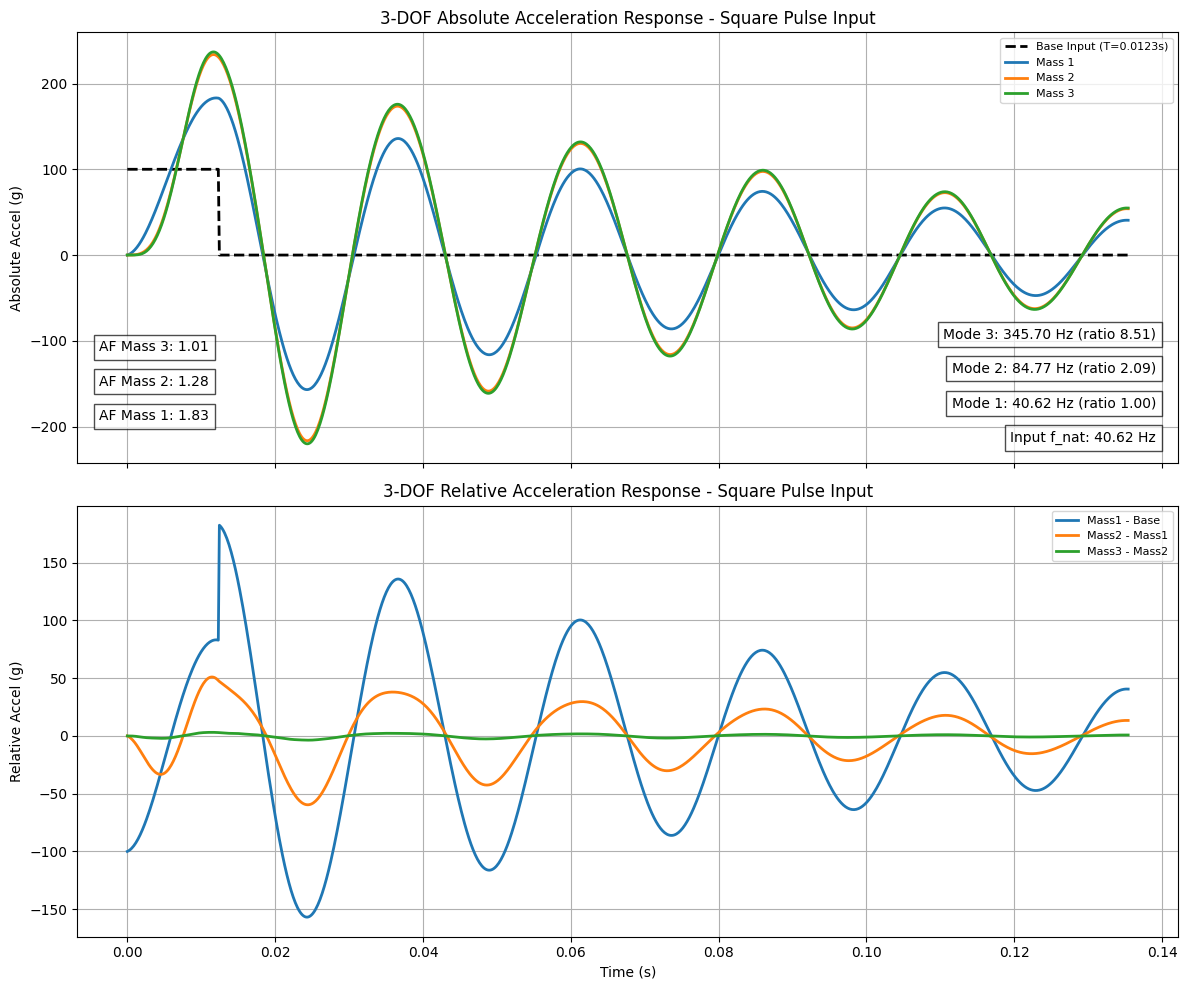

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 3-DOF Square Pulse Base Excitation Response

# Determine modal frequencies
f_mode1 = threedof.fn[0]          # lowest mode
f_mode_max = np.max(threedof.fn)  # highest mode

# Square pulse parameters
peak = 100.0                     # peak acceleration (g)

# Input natural frequency (Hz) - modify as desired
f_input = f_mode1                   # input natural frequency (Hz)
T_pulse = 1.0 / (2 * f_input)    # square pulse half-period (pulse duration)

# Total duration: input pulse + ringdown cycles based on lowest mode
cycles = 5                       # number of lowest-mode cycles to display
mode_period = 1.0 / f_mode1      # period of lowest mode
t_total = T_pulse + cycles * mode_period

# Sampling rate: highest mode * factor for smoothness
sample_factor = 20               # samples per cycle of highest mode
fs = f_mode_max * sample_factor

# Time vector
t = np.linspace(0, t_total, int(t_total * fs))

# Base acceleration: square pulse during pulse duration, zero after
a_base = np.zeros_like(t)
mask = t <= T_pulse
a_base[mask] = peak  # Square pulse - constant amplitude during pulse

# Compute 3-DOF time response
t_out, a_3d = time_response(threedof, t, a_base)

# Calculate amplification factors: peak absolute accel ratios
af1 = np.max(np.abs(a_3d[0])) / np.max(np.abs(a_base))
af2 = np.max(np.abs(a_3d[1])) / np.max(np.abs(a_3d[0]))
af3 = np.max(np.abs(a_3d[2])) / np.max(np.abs(a_3d[1]))

# Plot absolute and relative accelerations
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Absolute response
axs[0].plot(t, a_base, 'k--', label=f'Base Input (T={T_pulse:.4f}s)')
for idx in range(a_3d.shape[0]):
    axs[0].plot(t_out, a_3d[idx], label=f'Mass {idx+1}')
axs[0].set_ylabel('Absolute Accel (g)')
axs[0].set_title('3-DOF Absolute Acceleration Response - Square Pulse Input')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].grid(True)

# Annotate amplification factors in lower-left
text_y_start = 0.1
spacing = 0.08
for idx, af in enumerate([af1, af2, af3]):
    axs[0].text(0.02, text_y_start + idx * spacing,
                f'AF Mass {idx+1}: {af:.2f}',
                transform=axs[0].transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Annotate input and mode natural frequencies in lower-right
text_x = 0.98
text_y_start_r = 0.05
freq_lines = [f'Input f_nat: {f_input:.2f} Hz'] + [
    f'Mode {j+1}: {fn:.2f} Hz (ratio {fn/f_input:.2f})' for j, fn in enumerate(threedof.fn)
]
for j, line in enumerate(freq_lines):
    axs[0].text(text_x, text_y_start_r + j * spacing,
                line, transform=axs[0].transAxes,
                ha='right', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

# Relative accelerations: mass1-base, mass2-mass1, mass3-mass2
a_rel1 = a_3d[0] - a_base
a_rel2 = a_3d[1] - a_3d[0]
a_rel3 = a_3d[2] - a_3d[1]
axs[1].plot(t_out, a_rel1, label='Mass1 - Base')
axs[1].plot(t_out, a_rel2, label='Mass2 - Mass1')
axs[1].plot(t_out, a_rel3, label='Mass3 - Mass2')
axs[1].set_ylabel('Relative Accel (g)')
axs[1].set_title('3-DOF Relative Acceleration Response - Square Pulse Input')
axs[1].set_xlabel('Time (s)')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Square Pulse Amplification Factor

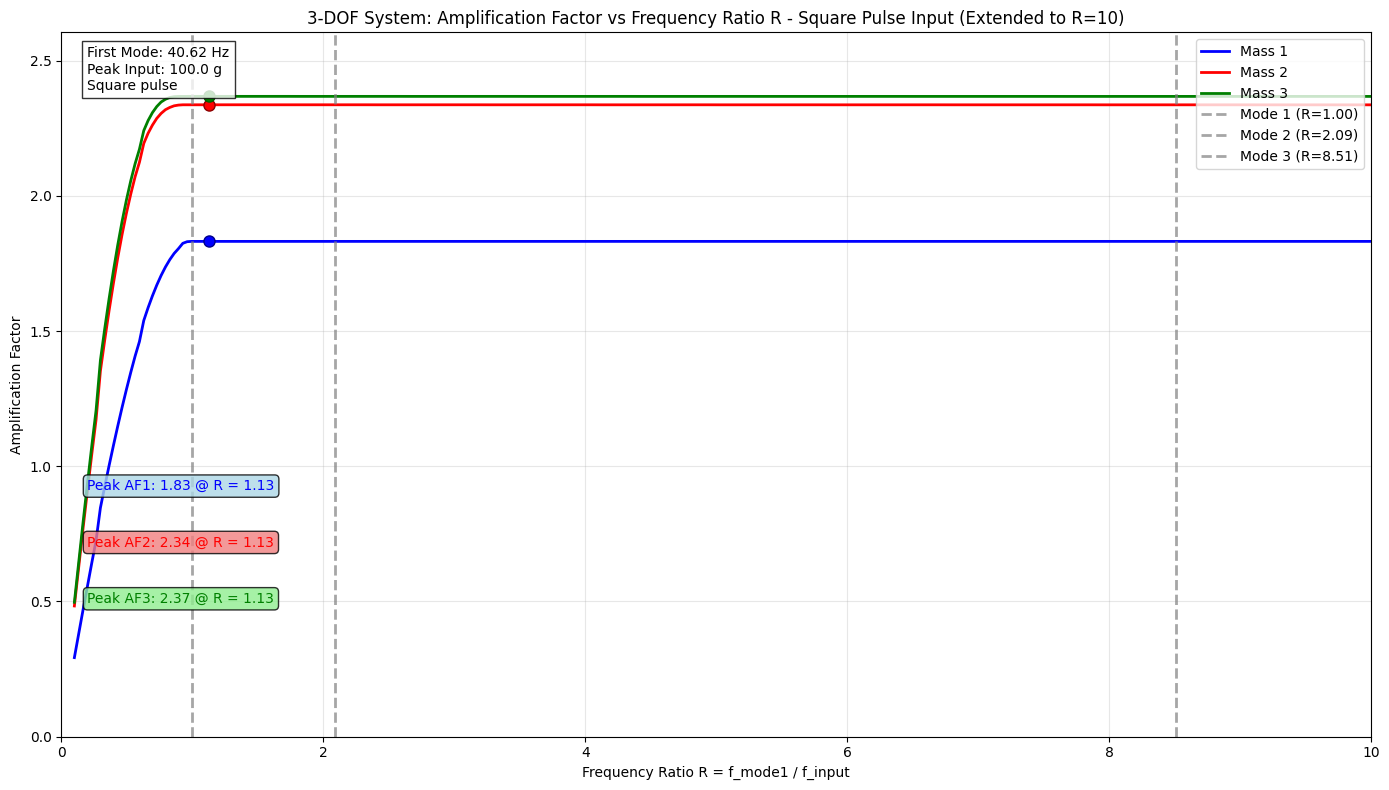

In [12]:
# Frequency Ratio (R) Study: Amplification Factor vs R - Square Pulse Input
# R = f_mode1 / f_input, where R ranges from 0.1 to 10

import numpy as np
import matplotlib.pyplot as plt

# Parameters
f_mode1 = threedof.fn[0]  # first mode frequency
peak = 100.0              # peak acceleration (g)

# Define R range (0.1 to 10) and corresponding input frequencies
R_values = np.linspace(0.1, 10.0, 300)  # Extended to 10 with more points for smoothness
f_input_values = f_mode1 / R_values     # f_input = f_mode1 / R

# Storage arrays for amplification factors
AF_mass1_sq = np.zeros_like(R_values)
AF_mass2_sq = np.zeros_like(R_values)
AF_mass3_sq = np.zeros_like(R_values)

# Loop through each input frequency
for i, f_input in enumerate(f_input_values):
    # Square pulse parameters
    T_pulse = 1.0 / (2 * f_input)  # pulse duration
    
    # Time parameters
    cycles = 3  # reduced for speed
    mode_period = 1.0 / f_mode1
    t_total = T_pulse + cycles * mode_period
    
    # Sampling
    sample_factor = 15  # reduced for speed
    fs = np.max(threedof.fn) * sample_factor
    t = np.linspace(0, t_total, int(t_total * fs))
    
    # Base acceleration: square pulse (constant amplitude during pulse)
    a_base = np.zeros_like(t)
    mask = t <= T_pulse
    a_base[mask] = peak  # Square pulse - constant amplitude
    
    # Compute response
    t_out, a_3d = time_response(threedof, t, a_base)
    
    # Calculate amplification factors
    AF_mass1_sq[i] = np.max(np.abs(a_3d[0])) / np.max(np.abs(a_base))
    AF_mass2_sq[i] = np.max(np.abs(a_3d[1])) / np.max(np.abs(a_base))
    AF_mass3_sq[i] = np.max(np.abs(a_3d[2])) / np.max(np.abs(a_base))

# Find peak amplification factors and their R values
peak_AF1_sq_idx = np.argmax(AF_mass1_sq)
peak_AF1_sq_R = R_values[peak_AF1_sq_idx]
peak_AF1_sq_value = AF_mass1_sq[peak_AF1_sq_idx]

peak_AF2_sq_idx = np.argmax(AF_mass2_sq)
peak_AF2_sq_R = R_values[peak_AF2_sq_idx]
peak_AF2_sq_value = AF_mass2_sq[peak_AF2_sq_idx]

peak_AF3_sq_idx = np.argmax(AF_mass3_sq)
peak_AF3_sq_R = R_values[peak_AF3_sq_idx]
peak_AF3_sq_value = AF_mass3_sq[peak_AF3_sq_idx]

# Plot amplification factors vs frequency ratio R
plt.figure(figsize=(14, 8))
plt.plot(R_values, AF_mass1_sq, 'b-', label='Mass 1', linewidth=2)
plt.plot(R_values, AF_mass2_sq, 'r-', label='Mass 2', linewidth=2)
plt.plot(R_values, AF_mass3_sq, 'g-', label='Mass 3', linewidth=2)

# Mark peak points on each curve
plt.plot(peak_AF1_sq_R, peak_AF1_sq_value, 'bo', markersize=8, markerfacecolor='blue', markeredgecolor='darkblue')
plt.plot(peak_AF2_sq_R, peak_AF2_sq_value, 'ro', markersize=8, markerfacecolor='red', markeredgecolor='darkred')
plt.plot(peak_AF3_sq_R, peak_AF3_sq_value, 'go', markersize=8, markerfacecolor='green', markeredgecolor='darkgreen')

# Add vertical lines at mode ratios
for j, fn in enumerate(threedof.fn):
    R_mode = fn / f_mode1
    if R_mode <= 10:  # Only show lines within the plot range
        plt.axvline(R_mode, color='gray', linestyle='--', alpha=0.7, 
                    label=f'Mode {j+1} (R={R_mode:.2f})' if j < 3 else None)

plt.xlabel('Frequency Ratio R = f_mode1 / f_input')
plt.ylabel('Amplification Factor')
plt.title('3-DOF System: Amplification Factor vs Frequency Ratio R - Square Pulse Input (Extended to R=10)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 10)  # Extended x-axis to 10
plt.ylim(0, np.max([AF_mass1_sq, AF_mass2_sq, AF_mass3_sq]) * 1.1)

# Add peak annotation boxes in lower left (no arrows)
peak_box_x = 0.02  # x position in axes coordinates
peak_box_y_start = 0.35  # starting y position
peak_box_spacing = 0.08  # vertical spacing between boxes

# Mass 1 peak info
plt.text(peak_box_x, peak_box_y_start, f'Peak AF1: {peak_AF1_sq_value:.2f} @ R = {peak_AF1_sq_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='blue',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))

# Mass 2 peak info
plt.text(peak_box_x, peak_box_y_start - peak_box_spacing, f'Peak AF2: {peak_AF2_sq_value:.2f} @ R = {peak_AF2_sq_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='red',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8))

# Mass 3 peak info
plt.text(peak_box_x, peak_box_y_start - 2*peak_box_spacing, f'Peak AF3: {peak_AF3_sq_value:.2f} @ R = {peak_AF3_sq_R:.2f}',
         transform=plt.gca().transAxes, fontsize=10, color='green',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

# Add annotation box with system info
info_text = f'First Mode: {f_mode1:.2f} Hz\nPeak Input: {peak} g\nSquare pulse'
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## SRS Analysis

### Half-sine Input SRS Calculation

Computing SRS for half-sine input...
Computing SRS for Mass 1 response...
Computing SRS for Mass 2 response...
Computing SRS for Mass 3 response...


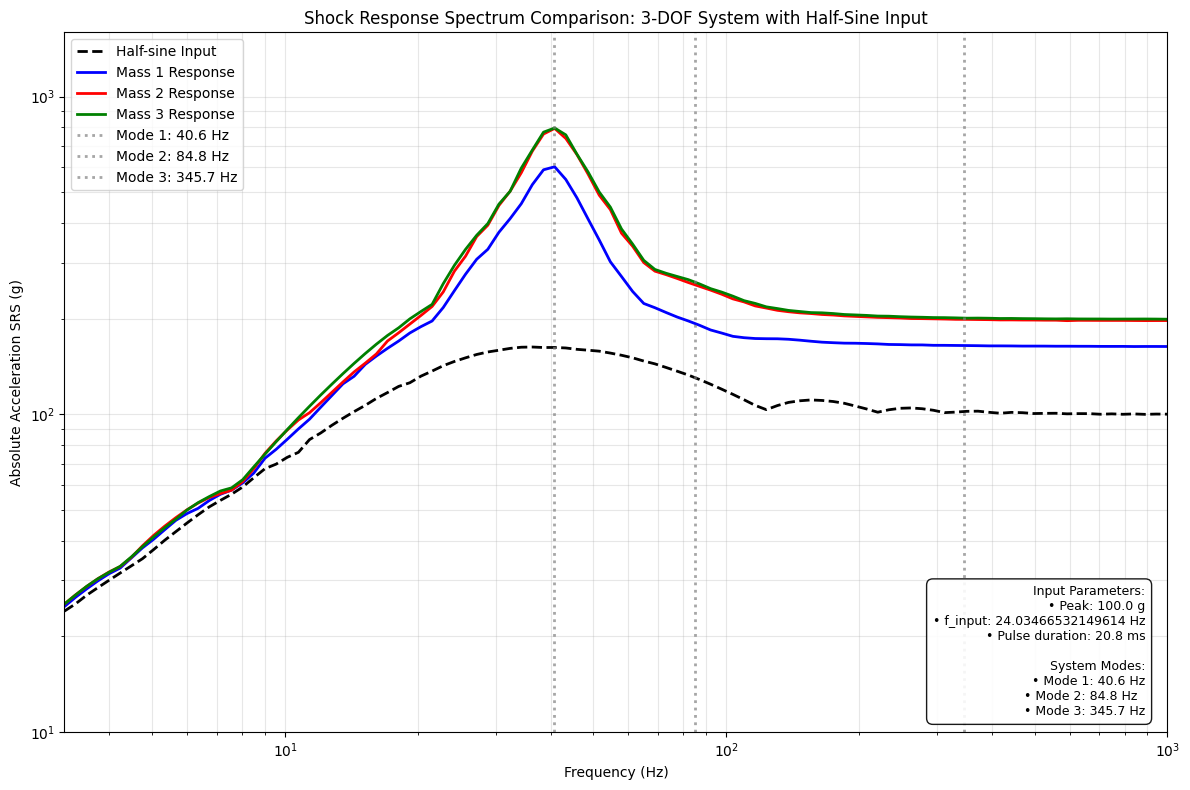


SRS Computation Complete!
Input peak: 162.8 g at 36.4 Hz
Mass 1 peak: 601.0 g at 40.8 Hz
Mass 2 peak: 793.5 g at 40.8 Hz
Mass 3 peak: 795.9 g at 40.8 Hz


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# SRS Comparison: Half-Sine Input vs 3-DOF Mass Responses

# Use the half-sine input and responses from cell 22
# (These should be available from the previous half-sine example)

# Get the half-sine input data - reconstruct from cell 22 parameters
f_input_srs = threedof.fn[0]/1.69  # Hz
T_pulse_srs = 1.0 / (2 * f_input_srs)
peak_srs = 100.0  # g

# Time parameters (match cell 22)
f_mode1_srs = threedof.fn[0]
cycles_srs = 5
mode_period_srs = 1.0 / f_mode1_srs
t_total_srs = T_pulse_srs + cycles_srs * mode_period_srs

# Sampling (match cell 22)
sample_factor_srs = 20
fs_srs = np.max(threedof.fn) * sample_factor_srs
t_srs = np.linspace(0, t_total_srs, int(t_total_srs * fs_srs))

# Recreate half-sine input
a_base_srs = np.zeros_like(t_srs)
mask_srs = t_srs <= T_pulse_srs
a_base_srs[mask_srs] = peak_srs * np.sin(np.pi * t_srs[mask_srs] / T_pulse_srs)

# Get 3-DOF response
t_out_srs, a_3d_srs = time_response(threedof, t_srs, a_base_srs)

# Define frequency range for SRS calculation
freq_srs_range = np.logspace(0.5, 3, 100)  # 3.16 Hz to 1000 Hz, 100 points

# Compute SRS for each signal
print("Computing SRS for half-sine input...")
srs_input = shock_response_spectrum(t_srs, a_base_srs, freq_srs_range, damping_ratio=0.05, speed_level='optimal')

print("Computing SRS for Mass 1 response...")
srs_mass1 = shock_response_spectrum(t_out_srs, a_3d_srs[0], freq_srs_range, damping_ratio=0.05, speed_level='optimal')

print("Computing SRS for Mass 2 response...")
srs_mass2 = shock_response_spectrum(t_out_srs, a_3d_srs[1], freq_srs_range, damping_ratio=0.05, speed_level='optimal')

print("Computing SRS for Mass 3 response...")
srs_mass3 = shock_response_spectrum(t_out_srs, a_3d_srs[2], freq_srs_range, damping_ratio=0.05, speed_level='optimal')

# Plot SRS comparison
plt.figure(figsize=(12, 8))

# Plot all SRS curves
plt.loglog(freq_srs_range, srs_input, 'k--', linewidth=2, label='Half-sine Input')
plt.loglog(freq_srs_range, srs_mass1, 'b-', linewidth=2, label='Mass 1 Response')
plt.loglog(freq_srs_range, srs_mass2, 'r-', linewidth=2, label='Mass 2 Response')
plt.loglog(freq_srs_range, srs_mass3, 'g-', linewidth=2, label='Mass 3 Response')

# Add vertical lines at modal frequencies
for j, fn in enumerate(threedof.fn):
    if fn <= 1000:  # Only show lines within frequency range
        plt.axvline(fn, color='gray', linestyle=':', alpha=0.7, 
                    label=f'Mode {j+1}: {fn:.1f} Hz' if j < 3 else None)

# Formatting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute Acceleration SRS (g)')
plt.title('Shock Response Spectrum Comparison: 3-DOF System with Half-Sine Input')
plt.grid(True, which="both", alpha=0.3)
plt.legend(loc='upper left', fontsize=10)
plt.xlim(freq_srs_range[0], freq_srs_range[-1])
plt.ylim(10, np.max([srs_input, srs_mass1, srs_mass2, srs_mass3]) * 2)

# Add info box with system parameters
info_box_text = f"""Input Parameters:
• Peak: {peak_srs} g
• f_input: {f_input_srs} Hz
• Pulse duration: {T_pulse_srs*1000:.1f} ms

System Modes:
• Mode 1: {threedof.fn[0]:.1f} Hz
• Mode 2: {threedof.fn[1]:.1f} Hz  
• Mode 3: {threedof.fn[2]:.1f} Hz"""

plt.text(0.98, 0.02, info_box_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"\nSRS Computation Complete!")
print(f"Input peak: {np.max(srs_input):.1f} g at {freq_srs_range[np.argmax(srs_input)]:.1f} Hz")
print(f"Mass 1 peak: {np.max(srs_mass1):.1f} g at {freq_srs_range[np.argmax(srs_mass1)]:.1f} Hz")
print(f"Mass 2 peak: {np.max(srs_mass2):.1f} g at {freq_srs_range[np.argmax(srs_mass2)]:.1f} Hz")
print(f"Mass 3 peak: {np.max(srs_mass3):.1f} g at {freq_srs_range[np.argmax(srs_mass3)]:.1f} Hz")